In [1]:
import numpy as np
import tensorflow as tf
from pprint import pprint
import cv2
import matplotlib.pyplot as plt
import pandas as pd

from utils import load_weights
from models import *

from tensorflow.keras import layers, regularizers, initializers, activations, models
import tensorflow.keras.backend as K

/usr/local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

In [2]:
input = layers.Input((416, 416, 3))
yolov4_output = yolov4(input, 80)
model1 = models.Model(input, yolov4_output)


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [27]:
img = cv2.imread('street.jpeg')[:,:,::-1]
img = cv2.resize(img, (416, 416))

imgs = np.expand_dims(img, axis=0)
imgs = imgs / 255.

In [4]:
load_weights(model1, 'yolov4.weights')

0
all read


In [46]:
def decode2(feature_maps, output_size, num_classes, strides, anchors, i, xyscale):
    conv_output = feature_maps
    XYSCALE = xyscale
    STRIDES = strides
    ANCHORS = anchors
    print(feature_maps.shape)
#     output_size = strides[i]
    feature_maps = tf.reshape(feature_maps,
                                 (tf.shape(feature_maps)[0], 
                                  output_size,
                                  output_size,
                                  3,
                                  5+num_classes)) # (batch_size, grid_size, grid_size, 3, 5+classes)
#     conv_output = tf.reshape(conv_output,
#                              (tf.shape(conv_output)[0], output_size, output_size, 3, 5 + num_classes))
    conv_raw_dxdy, conv_raw_dwdh, conv_raw_conf, conv_raw_prob = tf.split(feature_maps, 
                                                                          (2, 2, 1, num_classes),
                                                                         axis=-1)
    # (?, 16, 16, 3, 2) (?, 16, 16, 3, 2) (?, 16, 16, 3, 1) (?, 16, 16, 3, 80)
    print('conv_raw_dxdy, conv_raw_dwdh, conv_raw_conf, conv_raw_prob')
    print(conv_raw_dxdy.shape, conv_raw_dwdh.shape, conv_raw_conf.shape, conv_raw_prob.shape)
#     conv_raw_dxdy, conv_raw_dwdh, conv_raw_conf, conv_raw_prob = tf.split(conv_output, (2, 2, 1, num_classes),
#                                                                           axis=-1)
    # Create xy grid
    xy_grid = tf.meshgrid(tf.range(output_size), tf.range(output_size)) # (output_size, output_size) * 2
    xy_grid = tf.stack(xy_grid, axis=-1) # (grid x, grid y, 2)
    xy_grid = xy_grid[tf.newaxis, :, :, tf.newaxis, :] # (1, gx, gy, 1, 2)
    xy_grid = tf.tile(xy_grid, 
                      [tf.shape(feature_maps)[0], 1, 1, 3, 1]) # (batch_size, grid x, grid y, 3, 2)
    xy_grid = tf.cast(xy_grid, tf.float32)

    # Convert raw output to prediction
    pred_xy = ((tf.sigmoid(conv_raw_dxdy) * xyscale[i]) - 0.5 * (xyscale[i] - 1) + xy_grid) * strides[i] # (bs, grid_size, grid_size, 3, 2)
    pred_wh = (tf.exp(conv_raw_dwdh) * anchors[i]) # (bs, grid_size, grid_size, 3, 2)
    pred_xywh = tf.concat([pred_xy, pred_wh], axis=-1) # (bs, grid_size, grid_size, 3, 4)

    pred_conf = tf.sigmoid(conv_raw_conf)
    pred_prob = tf.sigmoid(conv_raw_prob)

    pred_prob = pred_conf * pred_prob # (bs, 16, 16, 3, 4)
    return pred_xywh, pred_prob

# decode output
def get_boxes(pred, anchors, classes, grid_size, strides, xyscale):
#     grid_size = tf.shape(pred)[1]
    ##
    pred = tf.reshape(pred,
                     (tf.shape(pred)[0], 
                      grid_size,
                      grid_size,
                      3,
                      5+classes)) # (batch_size, grid_size, grid_size, 3, 5+classes)
    ##
    box_xy, box_wh, object_probability, class_probabilities = tf.split(
        pred, (2, 2, 1, classes), axis=-1
    ) # (?, 52, 52, 3, 2) (?, 52, 52, 3, 2) (?, 52, 52, 3, 1) (?, 52, 52, 3, 80)
    
    box_xy = tf.sigmoid(box_xy) # (?, 52, 52, 3, 2)
    object_probability = tf.sigmoid(object_probability) # (?, 52, 52, 3, 1)
    class_probabilities = tf.sigmoid(class_probabilities) # (?, 52, 52, 3, 80)
    
    pred_box = tf.concat((box_xy, box_wh), axis=-1) # (?, 52, 52, 3, 4)
#     print(pred_box)
    
    grid = tf.meshgrid(tf.range(grid_size), tf.range(grid_size)) # (52, 52) (52, 52)
    grid = tf.expand_dims(tf.stack(grid, axis=-1), axis=2) # (52, 52, 1, 2)
    grid = tf.cast(grid, dtype=tf.float32)
    
#     box_xy = (box_xy + tf.cast(grid, tf.float32)) * strides
    box_xy = ((box_xy * xyscale) - 0.5 * (xyscale - 1) + grid) *strides
    
#     box_xy = (box_xy + tf.cast(grid, tf.float32)) / tf.cast(
#         grid_size, tf.float32
#     ) # (52, 52, 3, 2)
    
    box_wh = tf.exp(box_wh) * anchors
    box_x1y1 = box_xy - box_wh / 2
    box_x2y2 = box_xy + box_wh / 2
    bbox = tf.concat([box_x1y1, box_x2y2], axis=-1)
    return bbox, object_probability, class_probabilities, pred_box
def pre_nms(outputs):
    bs = tf.shape(outputs[0])[0]
    print(len(outputs)) # 3
    print('bs: ', bs)
    boxes = tf.zeros((bs, 0, 4))
    confidence = tf.zeros((bs, 0, 1))
    class_probabilities = tf.zeros((bs, 0, 80))
    
    for output_idx in range(0, len(outputs), 4):
        output_xy = outputs[output_idx]
        output_conf = outputs[output_idx+1]
        output_classes = outputs[output_idx+2]
#         bs = tf.shape(output_xy)[0]
#         boxes.append(tf.reshape(output_xy, (bs, -1, 4)))
#         conf.append(tf.reshape(output_conf, (bs, -1, 1)))
#         type_.append(tf.reshape(output_classes, (bs, -1, 80),))
        print(boxes.shape, output_xy.shape)
        boxes = tf.concat([boxes, tf.reshape(output_xy, (bs, -1, 4))], axis=1)
        confidence = tf.concat([confidence, tf.reshape(output_conf, (bs, -1, 1))], axis=1)
        class_probabilities = tf.concat([class_probabilities, tf.reshape(output_classes, (bs, -1, 80))], axis=1)
#         boxes.append(
#             tf.reshape(
#                 output[0], # (?, 52, 52, 3, 4)
#                 (tf.shape(output[0])[0], -1, tf.shape(output[0])[-1]), # (?, 52*52*3, 4)
#             )
#         )
#         conf.append(
#             tf.reshape(
#                 output[1], # (?, 52, 52, 3, 1)
#                 (tf.shape(output[1])[0], -1, tf.shape(output[1])[-1]), # (?, 52*52*3, 1)
#             )
#         )
#         type_.append(
#             tf.reshape(
#                 output[2], # (?, 52, 52, 3, 80)
#                 (tf.shape(output[2])[0], -1, tf.shape(output[2])[-1]), # # (?, 52*52*3, 80)
#             )
#         )

#     bbox = tf.concat(boxes, axis=1)
#     confidence = tf.concat(conf, axis=1)
#     class_probabilities = tf.concat(type_, axis=1)
    
    scores = confidence * class_probabilities

    print('concat: ', boxes.shape, confidence.shape, class_probabilities.shape, scores.shape)
    boxes = tf.expand_dims(boxes, axis=-2)
    boxes = boxes / 416
#     boxes = tf.reshape(boxes, (bs, -1, 1, 4))
#     scores = tf.reshape(scores, (bs, -1, 80))
    print('before nms: ', boxes.shape, scores.shape)
    print('before nms: ', boxes.dtype, scores.dtype)
    return boxes, scores

# NMS
def get_nms(outputs):
    """
    Apply non-max suppression and get valid detections.
    Args:
        outputs: yolo model outputs.

    Returns:
        boxes, scores, classes, valid_detections
    """
    boxes, scores = pre_nms(outputs)
    (
        boxes,
        scores,
        classes,
        valid_detections,
    ) = tf.image.combined_non_max_suppression(
        boxes=boxes, # y1x1, y2x2 [0~1]
        scores=scores,
        max_output_size_per_class=100, #self.max_boxes,
        max_total_size=100, # self.max_boxes, max_boxes: Maximum boxes in a single image.
        iou_threshold=0.1, # self.iou_threshold, iou_threshold: Minimum overlap that counts as a valid detection.
        score_threshold=0.1, # self.score_threshold, # Minimum confidence that counts as a valid detection.
    )
    return boxes, scores, classes, valid_detections

def get_detection_data(image, image_name, outputs, class_names):
    """
    Organize predictions of a single image into a pandas DataFrame.
    Args:
        image: Image as a numpy array.
        image_name: str, name to write in the image column.
        outputs: Outputs from inference_model.predict()
        class_names: A list of object class names.

    Returns:
        data: pandas DataFrame with the detections.
    """
    nums = outputs[-1]
    boxes, scores, classes = 3 * [None]
    if isinstance(outputs[0], np.ndarray):
        boxes, scores, classes = [
            item[0][: int(nums)] for item in outputs[:-1]
        ]
    if not isinstance(outputs[0], np.ndarray):
        boxes, scores, classes = [
            item[0][: int(nums)].numpy() for item in outputs[:-1]
        ]
    w, h = np.flip(image.shape[0:2])
#     w, h = 1., 1.
    data = pd.DataFrame(boxes, columns=['x1', 'y1', 'x2', 'y2'])
    data[['x1', 'x2']] = (data[['x1', 'x2']] * w).astype('int64')
    data[['y1', 'y2']] = (data[['y1', 'y2']] * h).astype('int64')
#     data[['x1', 'x2']] = (data[['x1', 'x2']] * w).astype('int64')
#     data[['y1', 'y2']] = (data[['y1', 'y2']] * h).astype('int64')
    data['object_name'] = np.array(class_names)[classes.astype('int64')]
    data['image'] = image_name
    data['score'] = scores
    data['image_width'] = w
    data['image_height'] = h
    data = data[
        [
            'image',
            'object_name',
            'x1',
            'y1',
            'x2',
            'y2',
            'score',
            'image_width',
            'image_height',
        ]
    ]
    return data

def draw_on_image(adjusted, detections):
    """
    Draw bounding boxes over the image.
    Args:
        adjusted: BGR image.
        detections: pandas DataFrame containing detections

    Returns:
        None
    """
    adjusted = adjusted.copy()
    for index, row in detections.iterrows():
        img, obj, x1, y1, x2, y2, score, *_ = row.values
        color = {
            class_name: color
            for class_name, color in zip(
                [str(i) for i in range(80)],
                [
                    list(np.random.random(size=3) * 256)
                    for _ in range(80)
                ],
            )
        }[obj]
        # self.box_colors.get(obj)
#         x1 = int(x1 * 416)
#         x2 = int(x2 * 416)
#         y1 = int(y1 * 416)
#         y2 = int(y2 * 416)
        cv2.rectangle(adjusted, (x1, y1), (x2, y2), color, 2)
        cv2.putText(
            adjusted,
            f'{obj}-{round(score, 2)}',
            (x1, y1 - 10),
            cv2.FONT_HERSHEY_COMPLEX_SMALL,
            0.6,
            color,
            1,
        )
    plt.figure(figsize=(20, 20))
    plt.imshow(adjusted)
    plt.show()

In [40]:
xyscale = [1.2, 1.1, 1.05] # cfg.YOLO.XYSCALE
anchors = np.array([12,16, 19,36, 40,28, 36,75, 76,55, 72,146, 142,110, 192,243, 459,401]) # utils.get_anchors(cfg.YOLO.ANCHORS)
anchors = np.array(anchors).reshape((3, 3, 2)) # (stage, bbox per grid, xy)
# print(anchors)
strides = [8, 16, 32]
output_sizes = [52, 26, 13]


In [48]:
yolov4_output = model1.output
boxes_0 = get_boxes(yolov4_output[0], anchors=anchors[0, :, :], classes=80, grid_size=52, strides=8, xyscale=xyscale[0])
boxes_1 = get_boxes(yolov4_output[1], anchors=anchors[1, :, :], classes=80, grid_size=26, strides=16, xyscale=xyscale[1])
boxes_2 = get_boxes(yolov4_output[2], anchors=anchors[2, :, :], classes=80, grid_size=13, strides=32, xyscale=xyscale[2])
boxes_0 #, boxes_1, boxes_2

(<tf.Tensor 'concat_59:0' shape=(?, 52, 52, 3, 4) dtype=float32>,
 <tf.Tensor 'Sigmoid_40:0' shape=(?, 52, 52, 3, 1) dtype=float32>,
 <tf.Tensor 'Sigmoid_41:0' shape=(?, 52, 52, 3, 80) dtype=float32>,
 <tf.Tensor 'concat_58:0' shape=(?, 52, 52, 3, 4) dtype=float32>)

In [49]:
model_boxes = models.Model(input, (boxes_0, boxes_1, boxes_2))

In [50]:
model_prenms = models.Model(input, pre_nms(model_boxes.outputs))

12
bs:  Tensor("strided_slice_22:0", shape=(), dtype=int32)
(?, 0, 4) (?, 52, 52, 3, 4)
(?, ?, 4) (?, 26, 26, 3, 4)
(?, ?, 4) (?, 13, 13, 3, 4)
concat:  (?, ?, 4) (?, ?, 1) (?, ?, 80) (?, ?, 80)
before nms:  (?, ?, 1, 4) (?, ?, 80)
before nms:  <dtype: 'float32'> <dtype: 'float32'>


In [51]:
model_yolo = models.Model(input, get_nms(model_boxes.outputs)) # [boxes, scores, classes, valid_detections]

12
bs:  Tensor("strided_slice_23:0", shape=(), dtype=int32)
(?, 0, 4) (?, 52, 52, 3, 4)
(?, ?, 4) (?, 26, 26, 3, 4)
(?, ?, 4) (?, 13, 13, 3, 4)
concat:  (?, ?, 4) (?, ?, 1) (?, ?, 80) (?, ?, 80)
before nms:  (?, ?, 1, 4) (?, ?, 80)
before nms:  <dtype: 'float32'> <dtype: 'float32'>


In [52]:
out = model_yolo.predict(imgs) 
# boxes, scores, classes, valid_detections

In [53]:
detections = get_detection_data(image=img, 
                                image_name='street', 
                                outputs=out, 
                                class_names=[str(i) for i in range(80)])

In [54]:
detections

,image,object_name,x1,y1,x2,y2,score,image_width,image_height
0,street,0,176,224,210,377,0.993157,416,416
1,street,0,223,235,250,381,0.968451,416,416
2,street,0,265,214,306,385,0.958894,416,416
3,street,0,332,247,361,385,0.910902,416,416
4,street,0,141,280,151,336,0.717211,416,416
5,street,0,127,289,137,344,0.428257,416,416
6,street,2,87,219,126,237,0.344773,416,416
7,street,7,11,215,56,249,0.308702,416,416
8,street,0,304,243,326,388,0.248488,416,416
9,street,2,206,213,222,230,0.108553,416,416


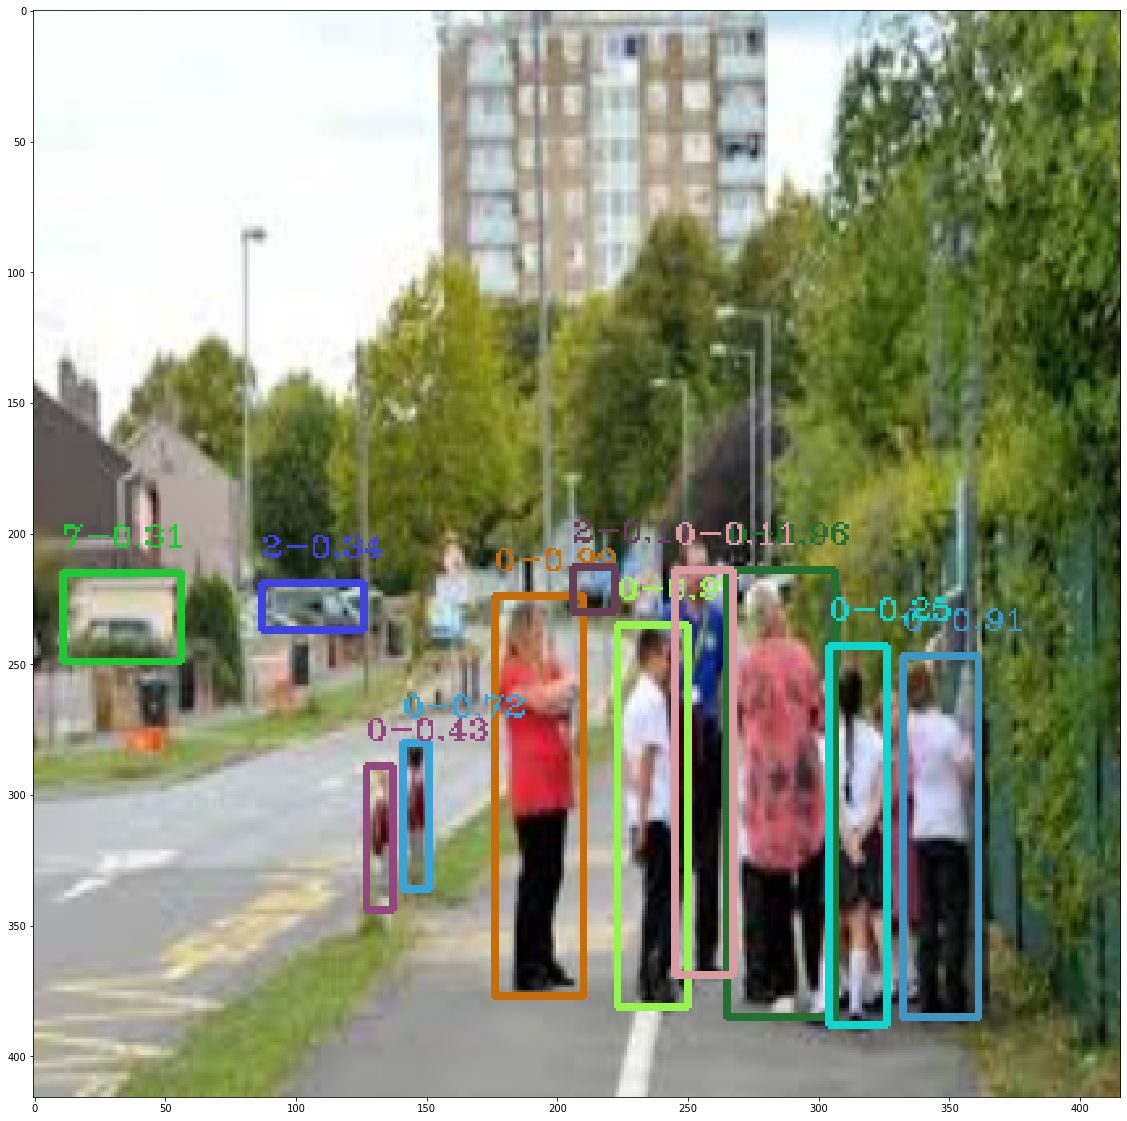

In [55]:
draw_on_image(img, detections)

In [30]:
detections

,image,object_name,x1,y1,x2,y2,score,image_width,image_height
0,street,0,177,224,211,376,0.993157,416,416
1,street,0,222,235,250,382,0.968451,416,416
2,street,0,264,213,306,385,0.958894,416,416
3,street,0,331,247,361,385,0.910902,416,416
4,street,0,141,280,151,336,0.717211,416,416
5,street,0,127,289,137,344,0.428257,416,416
6,street,2,87,219,126,237,0.344773,416,416
7,street,7,12,215,56,249,0.308702,416,416
8,street,0,304,243,326,388,0.248488,416,416
9,street,2,206,212,222,230,0.108553,416,416


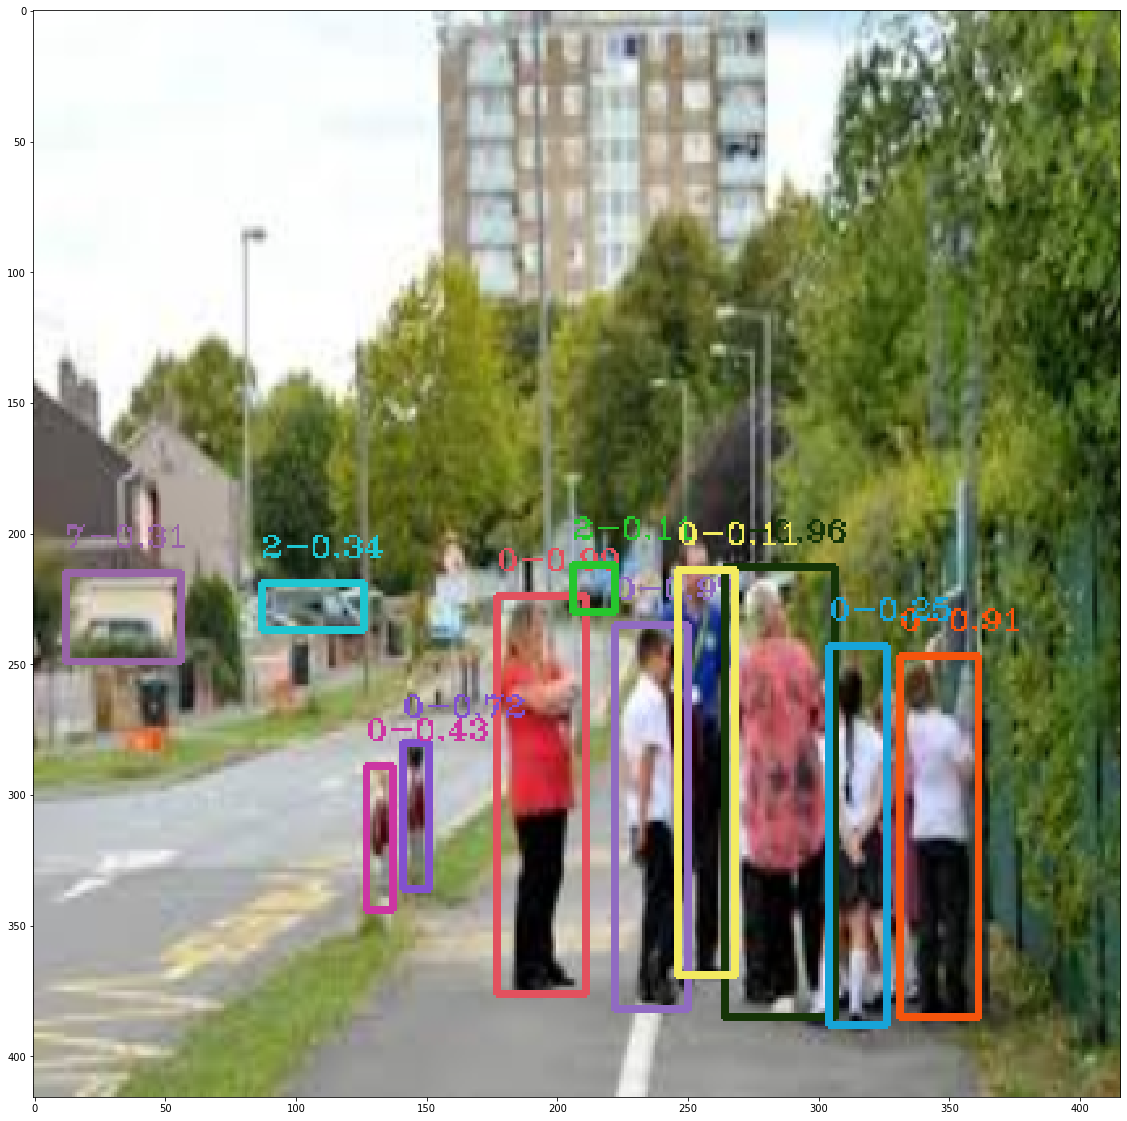

In [31]:
draw_on_image(img, detections)

In [81]:
detections

,image,object_name,x1,y1,x2,y2,score,image_width,image_height
0,street,0,177,224,211,376,0.993157,416,416
1,street,0,222,235,250,382,0.968451,416,416
2,street,0,264,213,306,385,0.958894,416,416
3,street,0,331,247,361,385,0.910902,416,416
4,street,0,141,280,151,336,0.717211,416,416
5,street,0,127,289,137,344,0.428257,416,416
6,street,2,87,219,126,237,0.344773,416,416
7,street,7,12,215,56,249,0.308702,416,416
8,street,0,304,243,326,388,0.248488,416,416
9,street,2,206,212,222,230,0.108553,416,416


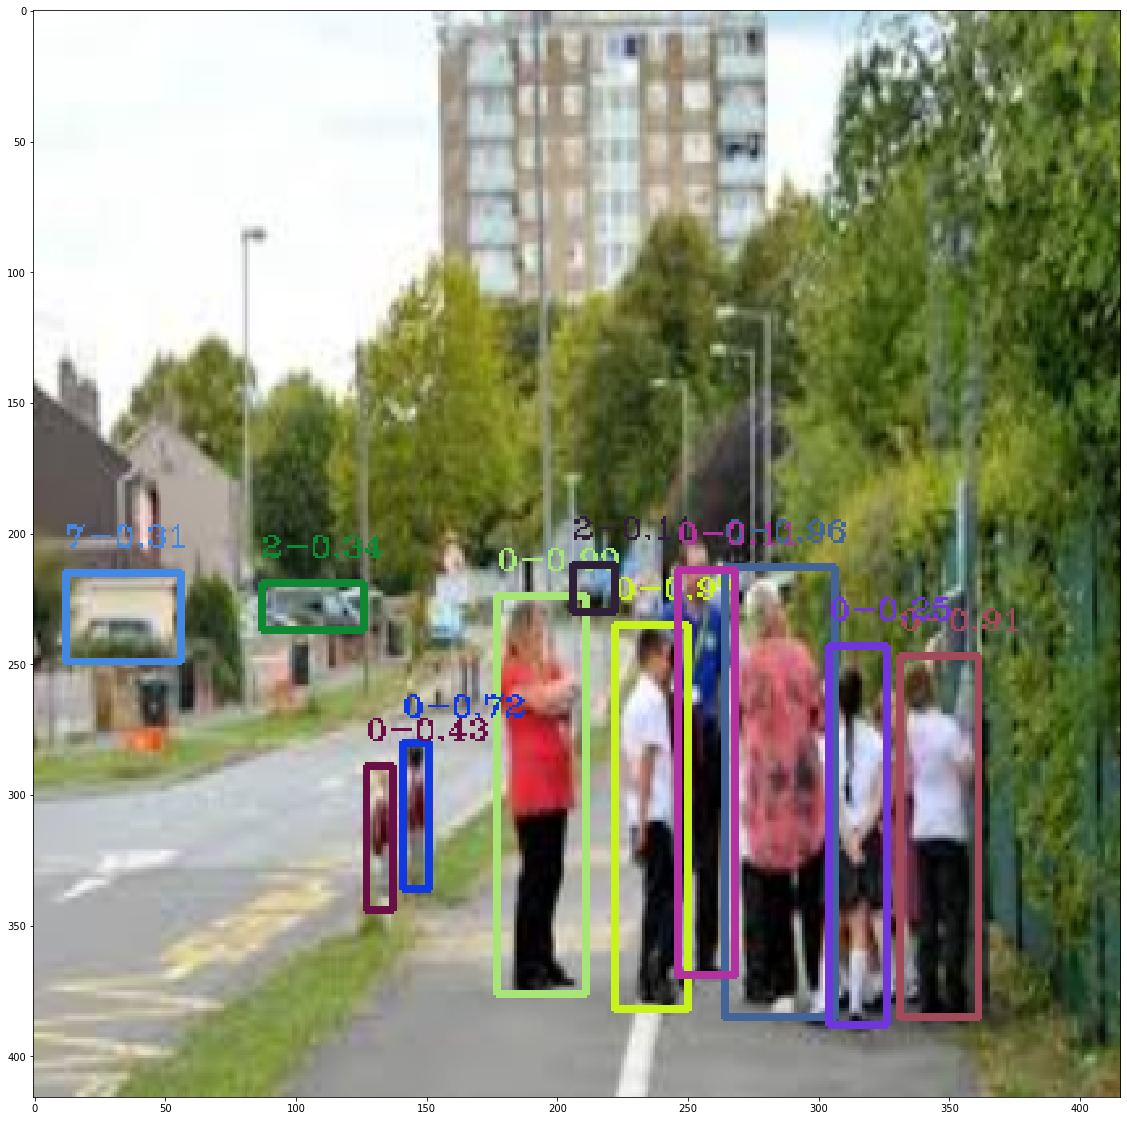

In [82]:
draw_on_image(img, detections)

In [98]:
# # decode output
# def get_boxes(pred, anchors, classes):
#     grid_size = tf.shape(pred)[1]
#     box_xy, box_wh, object_probability, class_probabilities = tf.split(
#         pred, (2, 2, 1, classes), axis=-1
#     )
#     box_xy = tf.sigmoid(box_xy)
#     object_probability = tf.sigmoid(object_probability)
#     class_probabilities = tf.sigmoid(class_probabilities)
#     pred_box = tf.concat((box_xy, box_wh), axis=-1)
#     grid = tf.meshgrid(tf.range(grid_size), tf.range(grid_size))
#     grid = tf.expand_dims(tf.stack(grid, axis=-1), axis=2)
#     box_xy = (box_xy + tf.cast(grid, tf.float32)) / tf.cast(
#         grid_size, tf.float32
#     )
#     box_wh = tf.exp(box_wh) * anchors
#     box_x1y1 = box_xy - box_wh / 2
#     box_x2y2 = box_xy + box_wh / 2
#     bbox = tf.concat([box_x1y1, box_x2y2], axis=-1)
#     return bbox, object_probability, class_probabilities, pred_box

In [51]:
model = models.Model(input, output_tensors)

In [52]:
model.summary()

Model: "model_10"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d_518 (Conv2D)             (None, 128, 128, 32) 864         input_7[0][0]                    
__________________________________________________________________________________________________
batch_normalization_506 (BatchN (None, 128, 128, 32) 128         conv2d_518[0][0]                 
__________________________________________________________________________________________________
leaky_re_lu_156 (LeakyReLU)     (None, 128, 128, 32) 0           batch_normalization_506[0][0]    
___________________________________________________________________________________________

In [15]:
input = layers.Input((128, 128, 3))
output = yolov4(input, 15)
model1 = models.Model(input, output)

In [16]:
model1.outputs

[<tf.Tensor 'conv2d_281/BiasAdd:0' shape=(?, 16, 16, 60) dtype=float32>,
 <tf.Tensor 'conv2d_289/BiasAdd:0' shape=(?, 8, 8, 60) dtype=float32>,
 <tf.Tensor 'conv2d_297/BiasAdd:0' shape=(?, 4, 4, 60) dtype=float32>]

In [17]:
model1.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d_188 (Conv2D)             (None, 128, 128, 32) 864         input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization_185 (BatchN (None, 128, 128, 32) 128         conv2d_188[0][0]                 
__________________________________________________________________________________________________
leaky_re_lu_45 (LeakyReLU)      (None, 128, 128, 32) 0           batch_normalization_185[0][0]    
____________________________________________________________________________________________

In [100]:
input = layers.Input((128, 128, 3))
output = cspdarknet53(input)
model2 = models.Model(input, output)

In [101]:
model2.output

(<tf.Tensor 'mul_697:0' shape=(?, 16, 16, 256) dtype=float32>,
 <tf.Tensor 'mul_718:0' shape=(?, 8, 8, 512) dtype=float32>,
 <tf.Tensor 'leaky_re_lu_260/LeakyRelu:0' shape=(?, 4, 4, 512) dtype=float32>)

In [102]:
model2.summary()

Model: "model_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_21 (InputLayer)           [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d_942 (Conv2D)             (None, 128, 128, 32) 864         input_21[0][0]                   
__________________________________________________________________________________________________
batch_normalization_941 (BatchN (None, 128, 128, 32) 128         conv2d_942[0][0]                 
__________________________________________________________________________________________________
leaky_re_lu_253 (LeakyReLU)     (None, 128, 128, 32) 0           batch_normalization_941[0][0]    
___________________________________________________________________________________________

In [94]:
# tf.keras.utils.plot_model(model2, show_shapes=True, show_layer_names=True)

In [27]:
# x = tf.reshape(tf.constant([[0, 1, 2], [3, 4, 5], [7, 8, 9]]), ((1, 3, 3, 1)))
# x = layers.ZeroPadding2D(padding=((1, 0), (1, 0)))(x)
# pprint(tf.keras.backend.eval(x).reshape(4, 4))

array([[0, 0, 0, 0],
       [0, 0, 1, 2],
       [0, 3, 4, 5],
       [0, 7, 8, 9]], dtype=int32)
